In [ ]:
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Data organization

In [ ]:
df = pd.read_csv('MEDS_OPEN_DATA.csv')
data = df[['PROCESS_FINALIZATION_DATE', 'REGULATORY_CATEGORY', 'THERAPEUTIC_CLASS']].copy()
data.rename(columns={'PROCESS_FINALIZATION_DATE': 'date','REGULATORY_CATEGORY': 'category','THERAPEUTIC_CLASS': 'class'}, inplace=True)
df.head()

,PRODUCT_TYPE,PRODUCT_NAME,PROCESS_FINALIZATION_DATE,REGULATORY_CATEGORY,PRODUCT_REGISTRATION_NUMBER,REGISTRATION_EXPIRATION_DATE,PROCESS_NUMBER,THERAPEUTIC_CLASS,REGISTRATION_HOLDER_COMPANY,REGISTRATION_STATUS,ACTIVE_INGREDIENT
0,MEDICAMENTO,(VITAMINAS A ) + ASSSOCIACÕES,25/04/2000,SIMILAR,104540166,01/04/2005,250000254169821,VITAMINAS E SUPLEMENTOS MINERAIS,60874187000184 - DAIICHI SANKYO BRASIL FARMACÊ...,CADUCO/CANCELADO,NaN
1,MEDICAMENTO,AC SALICILICO + AC BENZOICO + IODO,19/05/2000,SIMILAR,119350001,01/05/2005,2501017185899,ANTIMICOTICOS PARA USO TOPICO,63826069000199 - LABORATORIO FLORA DA AMAZONIA...,CADUCO/CANCELADO,NaN
2,MEDICAMENTO,ALENDRONATO SODICO,04/06/2001,SIMILAR,100470305,01/05/2006,253510228050056,SUPRESSORES DA REABSORCAO OSSEA,61286647000116 - SANDOZ DO BRASIL INDÚSTRIA FA...,CADUCO/CANCELADO,NaN
3,MEDICAMENTO,ARNICA MONTANA,19/03/2002,FITOTERÁPICO,104730021,01/03/2007,2502500782199,FITOTERAPICO SIMPLES,92762277000170 - VIDORA FARMACÊUTICA LTDA,CADUCO/CANCELADO,NaN
4,MEDICAMENTO,ARNICA MONTANA L.,01/07/2002,FITOTERÁPICO,131750004,01/06/2007,253510326310184,FITOTERAPICO SIMPLES,00925697000101 - LIMED LABORATORIO INDUSTRIAL ...,CADUCO/CANCELADO,NaN


### 1.1 Treating with Missing Data

In [ ]:
print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31317 entries, 0 to 31316
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      30799 non-null  object
 1   category  29440 non-null  object
 2   class     31236 non-null  object
dtypes: object(3)
memory usage: 734.1+ KB
None
date         518
category    1877
class         81
dtype: int64


In [ ]:
data.dropna(inplace=True)
print(data.isnull().sum())

date        0
category    0
class       0
dtype: int64


In [ ]:
data['date'] = pd.to_datetime(data['date'], format = '%d/%m/%Y', errors='coerce')
data.dropna(subset=['date'], inplace=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 28846 entries, 0 to 31316
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      28846 non-null  datetime64[ns]
 1   category  28846 non-null  object        
 2   class     28846 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 901.4+ KB
None


### 1.2 CLASS Organization

In [ ]:
data['class'].nunique()

687

In [ ]:
stop_words = set(stopwords.words('portuguese'))

def clean_text(text):
  text = str(text).lower()
  text = text.replace('+', '')
  text = ''.join(c for c in text if c.isalpha() or c.isspace())
  text = ' '.join([word for word in text.split() if word not in stop_words])
  return text

data['class'] = data['class'].apply(clean_text)


In [ ]:
# data['class'].unique()

In [ ]:
all_words = ' '.join([str(texto) for texto in data['class']])
all_words

'vitaminas suplementos minerais antimicoticos uso topico supressores reabsorcao ossea fitoterapico simples fitoterapico simples anestesicos antimicotico antinfecciosos antissepticos topicos orofaringe reidratantes parenterais diluentes veiculos medicamentos outros medicamentos acao aparelho cardiovascular analgesicos fitoterapico simples fitoterapico simples antivaricosos topicos fitoterapico simples fitoterapico simples imunomodulador expectorantes expectorantes fitoterapico simples antihipertensivos antimicotico antiulcerosos antibioticos sistemicos simples antineoplasico antinflamatorios antireumaticos antimicotico vacinas polivitaminicos minerais eletrolitos simples glicocorticoides topicos associacao medicamentosa glicocorticoides topicos associacao medicamentosa antinflamatorios antireumatiosassocs medicamentosas polivitaminicos minerais ceratoliticos ceratoplasticos antiespasmodicos anticolinergicosassoc medicamentosas antiespasmodicos anticolinergicosassoc medicamentosas anties

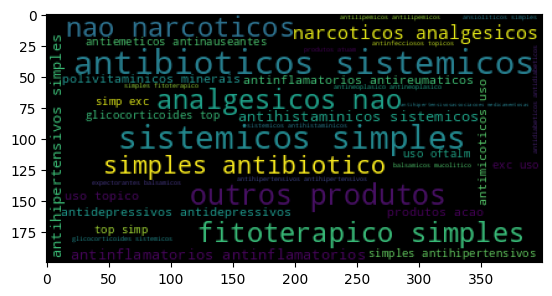

In [ ]:
class_wc = WordCloud().generate(all_words)
plt.figure()
plt.imshow(class_wc)
plt.show()

# 2. Data Evaluation

In [ ]:
# Time series
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['quarter'] = data['date'].dt.quarter

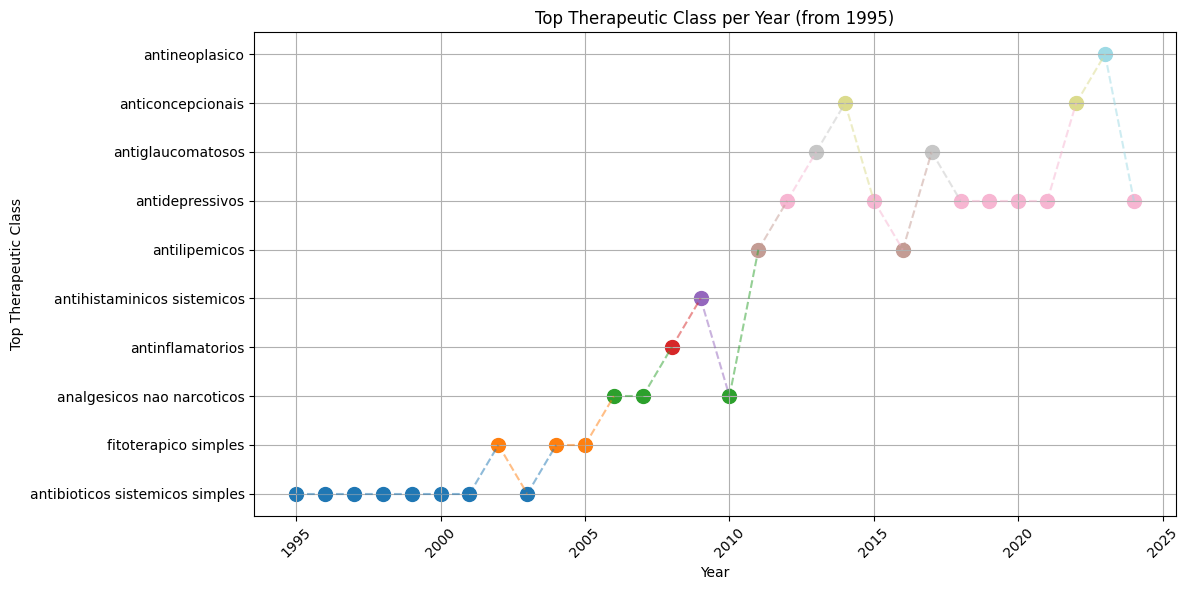

In [ ]:
# TOP Terapeutic Class

data_filtered = data[data['date'].dt.year >= 1995]
top_class_by_year = data_filtered.groupby('year')['class'].agg(lambda x: x.value_counts().index[0]).reset_index()

unique_classes = top_class_by_year['class'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))
class_color_map = {cls: colors[i] for i, cls in enumerate(unique_classes)}

plt.figure(figsize=(12, 6))

for year, cls in zip(top_class_by_year['year'], top_class_by_year['class']):
    plt.scatter(year, cls, color=class_color_map[cls], s=100)

for i in range(len(top_class_by_year)-1):
    year1, cls1 = top_class_by_year.iloc[i][['year', 'class']]
    year2, cls2 = top_class_by_year.iloc[i+1][['year', 'class']]
    plt.plot([year1, year2], [cls1, cls2], color=class_color_map[cls1], linestyle='--', alpha=0.5)

plt.xlabel('Year')
plt.ylabel('Top Therapeutic Class')
plt.title('Top Therapeutic Class per Year (from 1995)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

In [ ]:
therapeutic_class_counts = data_filtered.groupby(['year', 'class']).size().reset_index(name='amount')
top_therapeutic_class_by_year = therapeutic_class_counts.loc[therapeutic_class_counts.groupby('year')['amount'].idxmax()].reset_index()

top_therapeutic_class_by_year[['year', 'class', 'amount']]


,year,class,amount
0,1995,antibioticos sistemicos simples,13
1,1996,antibioticos sistemicos simples,83
2,1997,antibioticos sistemicos simples,74
3,1998,antibioticos sistemicos simples,43
4,1999,antibioticos sistemicos simples,61
5,2000,antibioticos sistemicos simples,104
6,2001,antibioticos sistemicos simples,127
7,2002,fitoterapico simples,109
8,2003,antibioticos sistemicos simples,71
9,2004,fitoterapico simples,39


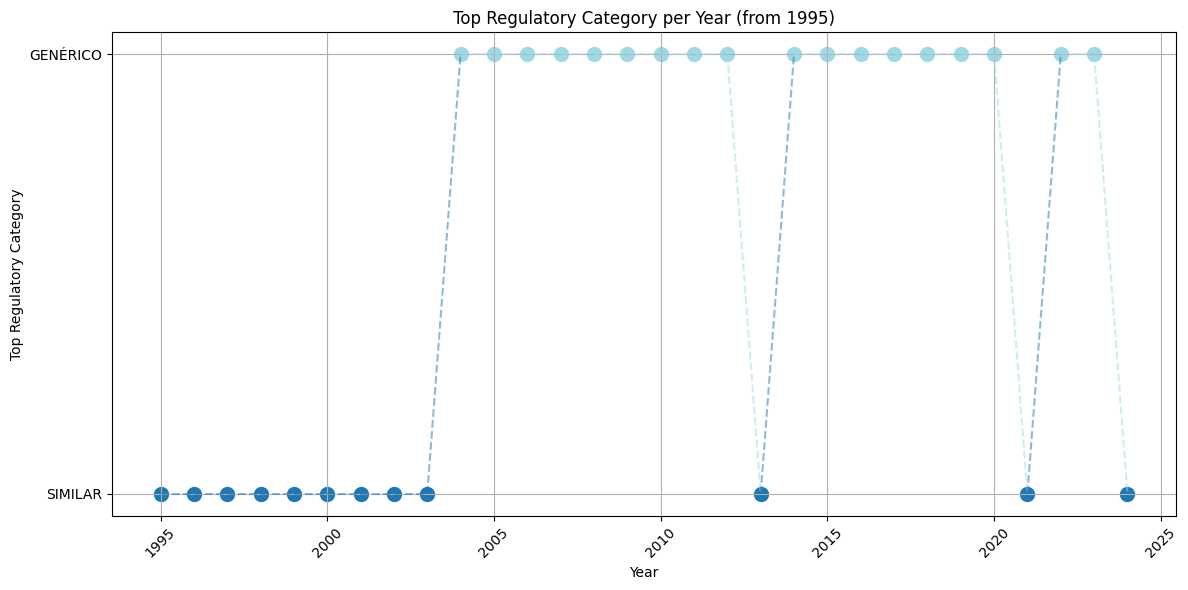

In [ ]:
# Top Category

top_category_by_year = data_filtered.groupby('year')['category'].agg(lambda x: x.value_counts().index[0]).reset_index()

unique_categories = top_category_by_year['category'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_categories)))
category_color_map = {cat: colors[i] for i, cat in enumerate(unique_categories)}

plt.figure(figsize=(12, 6))

for year, cat in zip(top_category_by_year['year'], top_category_by_year['category']):
    plt.scatter(year, cat, color=category_color_map[cat], s=100)

for i in range(len(top_category_by_year)-1):
    year1, cat1 = top_category_by_year.iloc[i][['year', 'category']]
    year2, cat2 = top_category_by_year.iloc[i+1][['year', 'category']]
    plt.plot([year1, year2], [cat1, cat2], color=category_color_map[cat1], linestyle='--', alpha=0.5)

plt.xlabel('Year')
plt.ylabel('Top Regulatory Category')
plt.title('Top Regulatory Category per Year (from 1995)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# 3. Forecasting

### 3.1 DecisionTree Model

In [ ]:
grouped_data = data_filtered.groupby(['year', 'month', 'category', 'class']).size().reset_index(name='count')
grouped_data.head()

,year,month,category,class,count
0,1995,1,ESPECÍFICO,vitaminas suplementos minerais,1
1,1995,1,SIMILAR,antiacido,1
2,1995,1,SIMILAR,antianemicos,1
3,1995,1,SIMILAR,imunoglobulinas,1
4,1995,1,SIMILAR,substitutos plasma expansores plasmaticos,1


In [ ]:
# grouped_data['count'].describe()

In [ ]:
grouped_data['category'].value_counts()

,count
category,
SIMILAR,8885
GENÉRICO,4943
NOVO,2572
ESPECÍFICO,1043
FITOTERÁPICO,735
BIOLÓGICO,591
DINAMIZADO,81
RADIOFÁRMACO,28
PRODUTO DE T,4


In [ ]:
le = LabelEncoder()
grouped_data['class_encoded'] = le.fit_transform(grouped_data['class'])
grouped_data['category_encoded'] = le.fit_transform(grouped_data['category'])
# grouped_data.head()

In [ ]:
x = grouped_data[['year', 'month', 'category_encoded', 'class_encoded']]
y = grouped_data['count']

In [ ]:
# Spliting data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 5)
x_train2, x_val, y_train2, y_val = train_test_split(x_train, y_train, test_size = 0.30, random_state = 5)

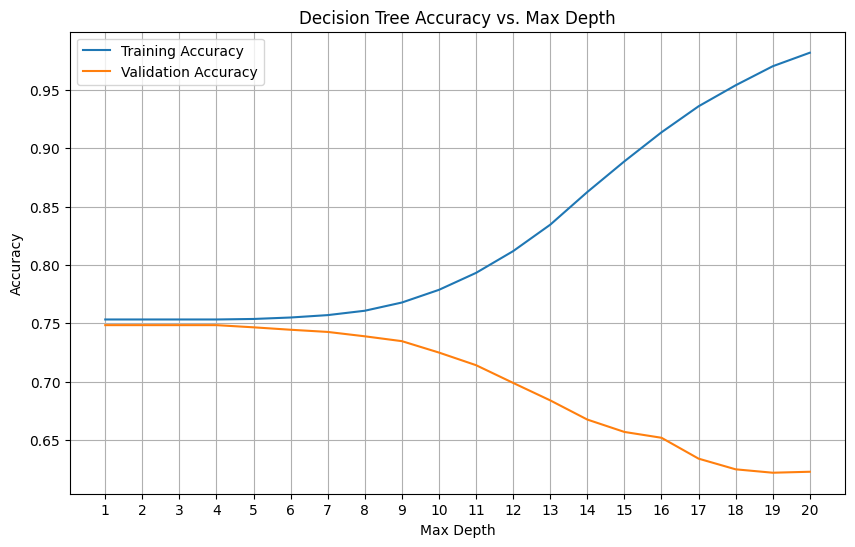

In [ ]:
def evaluate_max_depth(x_train, y_train, x_val, y_val):
    train_accuracy = []
    validation_accuracy = []
    max_depths = range(1, 21)  # Evaluate max_depth from 1 to 20

    for depth in max_depths:
        dt_model_eval = DecisionTreeClassifier(max_depth=depth)
        dt_model_eval.fit(x_train2, y_train2)
        train_accuracy.append(dt_model_eval.score(x_train2, y_train2))
        validation_accuracy.append(dt_model_eval.score(x_val, y_val))

    plt.figure(figsize=(10, 6))
    plt.plot(max_depths, train_accuracy, label='Training Accuracy')
    plt.plot(max_depths, validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.title('Decision Tree Accuracy vs. Max Depth')
    plt.xticks(max_depths)
    plt.legend()
    plt.grid(True)
    plt.show()

evaluate_max_depth(x_train2, y_train2, x_val, y_val)

In [ ]:
# Hyperparameter Tuning

param_dist = {'criterion': ['gini','entropy'],
              'max_depth': randint(1,20)}

dt_model_cv = DecisionTreeClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(dt_model_cv,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5,
                                 scoring='accuracy',
                                 random_state=42)

rand_search.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7af2b964ea50>},
                   random_state=42, scoring='accuracy')

In [ ]:
rand_search.best_params_

{'criterion': 'gini', 'max_depth': 7}

In [ ]:
dt_model = DecisionTreeClassifier(**rand_search.best_params_)
dt_model.fit(x_train2, y_train2)
print(f'Train accuracy: {dt_model.score(x_train, y_train)}')


Train accuracy: 0.7527571811327809


In [ ]:
y_pred = dt_model.predict(x_test)

print(f'Train Accuracy: {dt_model.score(x_train, y_train):4f}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred):4f}')
print(f'Precision: {precision_score(y_test, y_pred, average="weighted"):4f}')
print(f'Recall: {recall_score(y_test, y_pred, average="weighted"):4f}')
print(f'F1-score: {f1_score(y_test, y_pred, average="weighted"):4f}')

Train Accuracy: 0.752757
Test Accuracy: 0.757854
Precision: 0.616249
Recall: 0.757854
F1-score: 0.662761


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# prompt: create a model using random forest classifier

from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=8)  # You can adjust hyperparameters here
rf_model.fit(x_train2, y_train2)

# Evaluate the model
print(f'Train accuracy: {rf_model.score(x_train, y_train)}')
y_pred_rf = rf_model.predict(x_test)

print(f'Train Accuracy: {rf_model.score(x_train, y_train):4f}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred_rf):4f}')
print(f'Precision: {precision_score(y_test, y_pred_rf, average="weighted", zero_division=1):4f}') #Handle zero division
print(f'Recall: {recall_score(y_test, y_pred_rf, average="weighted", zero_division=1):4f}') #Handle zero division
print(f'F1-score: {f1_score(y_test, y_pred_rf, average="weighted", zero_division=1):4f}') #Handle zero division


Train accuracy: 0.911271730325877
Train Accuracy: 0.911272
Test Accuracy: 0.715849
Precision: 0.630780
Recall: 0.715849
F1-score: 0.665755


In [ ]:
# Future Dataframe
future_years = [2025]
future_months = range(1, 13)  # All 12 months

unique_categories = grouped_data['category_encoded'].unique()
unique_classes = grouped_data['class_encoded'].unique()

future_data = []
for year in future_years:
    for month in future_months:
        for cat in unique_categories: # only values seen by the LabelEncoder
            for cls in unique_classes: # only values seen by the LabelEncoder
                future_data.append([year, month, cat, cls])

future_df = pd.DataFrame(future_data, columns=['year', 'month', 'category_encoded', 'class_encoded'])

# Prediction
future_df['predicted_count'] = dt_model.predict(future_df)

# Mapping the dictionary
category_mapping = dict(zip(grouped_data['category_encoded'], grouped_data['category']))
class_mapping = dict(zip(grouped_data['class_encoded'], grouped_data['class']))
future_df['category'] = future_df['category_encoded'].map(category_mapping)
future_df['class'] = future_df['class_encoded'].map(class_mapping)

In [ ]:
future_df['predicted_count'].describe()

,predicted_count
count,72144.000000
mean,1.006293
std,0.222986
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,9.000000


In [ ]:
# future_df.head()

In [ ]:
filtered_future_df = future_df[future_df['predicted_count'] >= 3].reset_index(drop=True)
filtered_future_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              56 non-null     int64 
 1   month             56 non-null     int64 
 2   category_encoded  56 non-null     int64 
 3   class_encoded     56 non-null     int64 
 4   predicted_count   56 non-null     int64 
 5   category          56 non-null     object
 6   class             56 non-null     object
dtypes: int64(5), object(2)
memory usage: 3.2+ KB


In [ ]:
filtered_future_df['category'].value_counts()

,count
category,
ESPECÍFICO,14
FITOTERÁPICO,14
BIOLÓGICO,14
DINAMIZADO,14
